# Prioritised Experience Replay from Scratch

Prioritised Experience Replay (PER) aims to choose samples to replay such that they are most effective for learning.

# Imports & Constants

In [1]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import operator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import highway_env
import random

from typing import Dict, List, Tuple, Callable
from IPython.display import clear_output
import pandas as pd

from buffers import NStepReplayBuffer
from networks import Network
from agents import MlpDQNAgent

# Segment Tree

In [3]:
class SegmentTree:
    """
    Class representing a SegmentTree. 
    
    This code has been more or less copied from OpenAI baselines:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    The point of re-writing it is to make sure I have an understanding of how SegmentTrees work.
    """

    def __init__(self, capacity: int, operation: Callable, neutral_value: float):
        """
        Instantiates a SegmentTree.

        :param capacity: the maximum capacity of the tree.
        :param operation: the operation performed by calling `reduce`.
        :param neutral_value: ...
        """
        self.capacity = capacity
        self.tree = [neutral_value for _ in range(2 * capacity)]
        self.operation = operation

    def _reduce_helper(self, start: int, end: int, node: int, node_start: int, node_end: int) -> float:
        """
        Returns the result of `self.operation` in segment.
        """
        if start == node_start and end == node_end:
            return self.tree[node]
        
        mid = (node_start + node_end) // 2

        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self.operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )        

    def reduce(self, start: int, end: int = 0) -> float:
        """
        Returns the result of applying `self.operation` to a contiguous
        subsequence of the array.

        :param start: the beginning of the subsequence.
        :param end: the end of the subsequence.
        """
        if end <= 0:
            end += self.capacity
        end -= 1
        
        return self._reduce_helper(start, end, 1, 0, self.capacity - 1)
    
    def __setitem__(self, idx: int, val: float):
        """
        Sets a value in tree.
        """
        # Index of the leaf
        idx += self.capacity
        self.tree[idx] = val

        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx: int) -> float:
        """
        Gets the real value in the corresponding leaf node of tree.
        """
        return self.tree[self.capacity + idx]
    

class SumSegmentTree(SegmentTree):
    """
    Class representing a segment tree of sums.
    """
    
    def __init__(self, capacity: int):
        """
        Instantaites a SumSegmentTree.

        :param capacity: the maximum capacity of the tree.
        """
        super().__init__(capacity, operator.add, 0.0)

    def sum(self, start: int = 0, end: int = 0) -> float:
        """
        Returns arr[start] + ... + arr[end].
        """
        return self.reduce(start, end)
    
    def retrieve(self, upperbound: float) -> int:
        """
        Finds the highest index `i` about upper bound in the tree.
        """
        idx = 1

        # While non-leaf node.
        while idx < self.capacity:
            left = 2 * idx
            right = left + 1

            if self.tree[left] > upperbound:
                idx = 2 * idx
            else:
                upperbound -= self.tree[left]
                idx = right

        return idx - self.capacity
    

class MinSegmentTree(SegmentTree):
    """
    Class representing a segment tree of minimums.
    """

    def __init__(self, capacity: int):
        """
        Instantiates a MinSegmentTree.

        :param capacity: the maximum capacity of the tree.
        """
        super().__init__(capacity, min, float("inf"))

    def min(self, start: int = 0, end: int = 0) -> float:
        """
        Returns min(arr[start], ..., arr[end])
        """
        return self.reduce(start, end)

# Prioritised Replay Buffer

The key algorithmic concept of a PER is its use of _Segment Trees_. Segment Trees are special kind of datastructure which are extremely efficient at storing and sampling transitions while managing the priorities of them.

In [4]:
class PrioritisedReplayBuffer(NStepReplayBuffer):
    """
    Class representing a Prioritised Replay Buffer with N-step returns.
    """

    def __init__(
            self, 
            obs_shape: Tuple, 
            size: int, 
            batch_size: int = 32, 
            alpha: float = 0.6,
            n_step: int = 1,
            gamma: float = 0.99,
        ):
        """
        Instantiates a PrioritisedReplayBuffer.
        """
        super().__init__(obs_shape, size, batch_size, n_step, gamma)
        self.alpha = alpha

        self.max_priority = 1
        self.tree_ptr = 0

        # The capacity must be positive and a power of 2.
        tree_capcity = 1
        while tree_capcity < self.max_size:
            tree_capcity *= 2

        self.sum_tree = SumSegmentTree(tree_capcity)
        self.min_tree = MinSegmentTree(tree_capcity)

    def store(self, obs: np.ndarray, act: np.ndarray, rew: np.ndarray, next_obs: np.ndarray, done: bool):
        """
        Stores the experience and its associated priority.
        """
        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size

        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """
        Samples a batch of experiences with prioritised replay.
        """
        indices = self._sample_proportional()
        weights = np.array([self._calculate_weight(idx, beta) for idx in indices])

        return dict(
            obs=self.obs_buf[indices],
            next_obs=self.next_obs_buf[indices],
            acts=self.acts_buf[indices],
            rews=self.rews_buf[indices],
            done=self.done_buf[indices],
            weights=weights,
            indices=indices,
        )
    
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """
        Updates the priorities of sample transitions.
        """
        for idx, priority in zip(indices, priorities):
            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self) -> List[int]:
        """
        Samples indices based on proportions.
        """
        indices = []
        p_total = self.sum_tree.sum(0, self.size - 1)
        segment = p_total / self.batch_size

        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)

        return indices
    
    def _calculate_weight(self, idx: int, beta: float) -> float:
        """
        Calculates the weight of the experience at `idx`.
        """
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * self.size) ** (-beta)

        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * self.size) ** (-beta)
        weight = weight / max_weight
        
        return weight

# DQN with PER

In [5]:
class MlpDQNWithPERAgent(MlpDQNAgent):
    """
    Class representing a DQN with Prioritised Experience Replay Agent.
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        # PER Parameters.
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
    ):
        super().__init__(
            env,
            memory_size,
            batch_size,
            target_update,
            epsilon_decay,
            seed,
            max_epsilon,
            min_epsilon,
            gamma
        )

        # Prioritised Experience Replay settings.
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritisedReplayBuffer(self.obs_shape, memory_size, batch_size, alpha)
    
    def update_model(self) -> torch.Tensor:
        """
        Updates the model by gradient descent.
        """
        # PER uses beta to calculate weights.
        samples = self.memory.sample_batch(self.beta)

        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]

        # PER: Calculate importance sampling before the average.
        elementwise_loss = self._compute_dqn_loss(samples)
        loss = torch.mean(elementwise_loss * weights)
        
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # PER: Update experience priorities.
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        return loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """
        Trains the agent.
        """
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)

        update_count = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # PER: increase beta
            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            if done:
                # The episode has ended.
                state, _ = self.env.reset(seed=self.seed)
                
                scores.append(score)
                score = 0

            if len(self.memory) >= self.batch_size:
                # Training is ready once the replay buffer contains enough transition samples.
                loss = self.update_model()
                losses.append(loss)
                update_count += 1

                # Linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon,
                    self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                # If a hard update of the target network is needed.
                if update_count % self.target_update == 0:
                    self._target_hard_update()

            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)

        self.env.close()

        return scores, losses, epsilons

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float = None) -> torch.Tensor:
        """
        Computes and returns the DQN loss.
        """
        if gamma is None:
            gamma = self.gamma

        device = self.device
        # Shape = (batch_size, obs dim 1, obs dim 2, ...)
        # This flattens the observation dimensions of `state` and `next_state`.
        state = torch.FloatTensor(samples["obs"].reshape(self.batch_size, -1)).to(device)
        next_state = torch.FloatTensor(samples["next_obs"].reshape(self.batch_size, -1)).to(device)

        # Reshapes each 1-dimesional array into a 2-dimensional array with one column.
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t = r + gamma * v(s_{t+1}) if state != terminal
        #     = r                      otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        
        mask = 1 - done
        target = (reward + gamma * next_q_value * mask).to(device)

        # Calculate element-wise DQN loss
        loss = F.smooth_l1_loss(curr_q_value, target, reduction="none")

        return loss

# Train an agent

In [18]:
config = {
    'duration': 50,
    'lanes_count': 4,
}

In [19]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [8]:
seed = 777
num_frames = 200_000
memory_size = 10_000
gamma = 0.85
batch_size = 64
target_update = 50
epsilon_decay = 1 / (num_frames // 10)

agent = MlpDQNWithPERAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

cuda


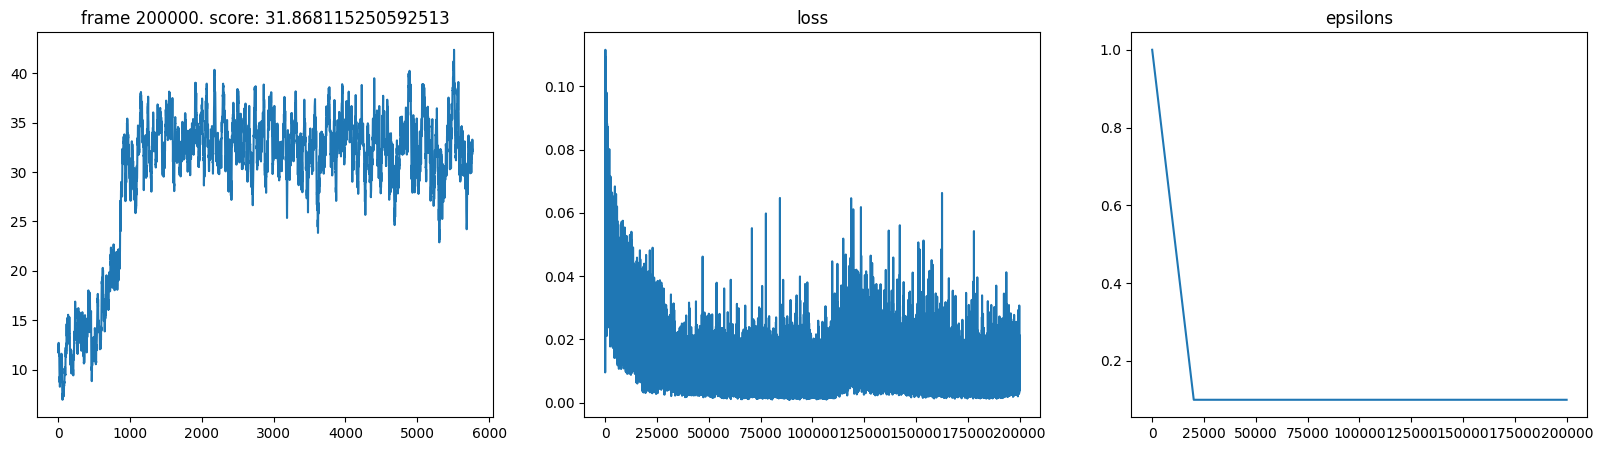

In [9]:
scores, losses, epsilons = agent.train(num_frames)

In [10]:
# pd.DataFrame({"DQN with Prioritised Replay": scores}).to_csv("../results/per_dqn.csv")

# Test the agent

In [ ]:
ep_lens, ep_rews = agent.test(5, time_interval=0.01)

In [12]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 14.0
Mean Score Per Episode: 10.622264613870291


# Film the agent

In [26]:
from gymnasium.wrappers import RecordVideo
from agents import BaseDQNAgent

In [27]:
env = gym.make("highway-v0", render_mode="rgb_array")

In [28]:
def film(env: gym.Env, test_agent: BaseDQNAgent, film_length: int, video_folder: str):
    vid_env = RecordVideo(env, video_folder=video_folder,
              episode_trigger=lambda e: True)  # record all episodes

    # Provide the video recorder to the wrapped environment
    # so it can send it intermediate simulation frames.
    vid_env.unwrapped.set_record_video_wrapper(vid_env)

    test_agent.set_mode(is_test=True)

    for i in range(film_length):
        obs, info = vid_env.reset()
        done = truncated = False

        while not (done or truncated):
            action = test_agent.predict(obs, determinstic=True)
            obs, reward, done, truncated, info = vid_env.step(action)
            vid_env.render()
        vid_env.close()

## Before Training

In [29]:
untrained_agent = MlpDQNWithPERAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

film(env, untrained_agent, 10, "../videos/dqn_per/untrained/")

cuda


/home/sowell/projects/rl_group_assignment/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-0.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-1.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-4.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-6.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-7.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/untrained/rl-video-episode-9.mp4


## After training

In [30]:
film(env, agent, 10, "../videos/dqn_per/trained/")

/home/sowell/projects/rl_group_assignment/venv/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-0.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-0.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-1.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-1.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-2.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-2.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-3.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-3.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-4.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-4.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-5.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-5.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-6.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-6.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-7.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-7.mp4


Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-8.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-8.mp4
Moviepy - Building video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-9.mp4.
Moviepy - Writing video /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /home/sowell/projects/rl_group_assignment/videos/dqn_per/trained/rl-video-episode-9.mp4
